Install CUDA version of the BLAS libraries

In [ ]:
!pip install nvidia-cublas-cu11

Install the 'vanilla' pennylane package first.

In [ ]:
!pip install pennylane

Now we build the "lightning" and "lightning-gpu" device code from source. We could probably use pre-packaged versions but this is what i managed to get working. I'll play with using the pre-packaged versions sometime soon.

In [3]:
!git clone https://github.com/PennyLaneAI/pennylane-lightning.git

Cloning into 'pennylane-lightning'...


In [ ]:
import os
os.chdir("pennylane-lightning")
!pip install -r requirements.txt
!pip install -e . -vv

In [ ]:
!python -m pip install wheel custatevec-cu11

In [6]:
import os
import site
os.environ["CUQUANTUM_SDK"] = f'{site.getsitepackages()[0]}/cuquantum/lib'

In [ ]:
!PL_BACKEND="lightning_gpu" python -m pip install -e . -vv

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F

import pennylane as qml
from pennylane import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Note that here we make use of the "lightning.gpu" device in order to have the pennylane code access the GPU.  Also a couple of lines to test that it's actually doing what's expected.

In [ ]:
n_qubits = 4
if use_cuda is True:
    dev = qml.device("lightning.gpu", wires=n_qubits)
else:
    dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(inputs, weights):
    # Original ansatz architecture
    '''
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    '''
    
    # Architecture 3
    '''
    for i in range(4):
        qml.RY(inputs[i], wires=i)
    
    for i in range(4):
        qml.RX(weights[0, 0], wires=i)
        qml.RY(weights[0, 1], wires=i)
    
    for i in range(4):
        qml.CNOT(wires=[i, (i + 1) % 4])
    
    for i in range(4):
        qml.RZ(weights[1, 0], wires=i)
        qml.RX(weights[1, 1], wires=i)
    '''

    # Architecture 5
    '''
    expanded_weights = torch.zeros(2, 4, 3)
    expanded_weights[:, :, 0] = weights[:, 0].unsqueeze(0).expand(2, 2).reshape(2, 2).repeat(1, 2)
    expanded_weights[:, :, 1] = weights[:, 1].unsqueeze(0).expand(2, 2).reshape(2, 2).repeat(1, 2)
    expanded_weights[:, :, 2] = (weights[:, 0] + weights[:, 1]).unsqueeze(0).expand(2, 2).reshape(2, 2).repeat(1, 2) * 0.5

    for i in range(n_qubits):
        qml.RY(inputs[i] * np.pi, wires=i)
    
    for layer in range(1):
        for i, wire in enumerate(range(4)):
            qml.RX(expanded_weights[layer, i, 0], wires=wire)
            qml.RY(expanded_weights[layer, i, 1], wires=wire)
            qml.RZ(expanded_weights[layer, i, 2], wires=wire)
        
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
    '''
    
    # Architecture 4
    '''
    flattened_weights = weights.flatten()
    
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    for i in range(n_qubits):
        qml.RY(flattened_weights[i], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])
    
    for i in range(n_qubits):
        qml.RZ(flattened_weights[i], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])
    '''

    # Architecture 2
    '''
    for i in range(4):
        qml.RY(np.pi * np.clip(inputs[i], 0.0, 1.0), wires=i)

    w_flat = np.reshape(weights, (-1,))  # shape (4,)

    for i in range(4):
        qml.RY(w_flat[i], wires=i)

    # gates: RXX(w0) on (0,1), RYY(w1) on (1,2), RXX(w2) on (2,3), RYY(w3) on (3,0)
    qml.IsingXX(w_flat[0], wires=[0, 1])
    qml.IsingYY(w_flat[1], wires=[1, 2])
    qml.IsingXX(w_flat[2], wires=[2, 3])
    qml.IsingYY(w_flat[3], wires=[3, 0])

    for i in range(4):
        qml.RZ(w_flat[i] * 0.5, wires=i)
    '''

    # Architecture 1

    qml.AngleEmbedding(inputs, wires=range(4), rotation='Y')
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])
    
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])

    w_flat = weights.flatten()
    
    qml.RY(w_flat[0], wires=0)
    qml.RY(w_flat[1], wires=1)
    qml.RY(w_flat[2], wires=2)
    qml.RY(w_flat[3], wires=3)
    

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(4)]

print(f"{dev=}")

input = torch.from_numpy(np.random.uniform(0, np.pi, (4,))).to(device)
weights = torch.from_numpy(np.random.uniform(0, np.pi, (2, 2))).to(device)
output = circuit(input, weights)
print(f"{output=}")
drawer = qml.draw(circuit)
print(drawer(input, weights))

dev=<default.qubit device (wires=4) at 0x1ae31a63110>
output=[tensor(-0.9852, dtype=torch.float64), tensor(-0.9870, dtype=torch.float64), tensor(-0.8988, dtype=torch.float64), tensor(-0.2443, dtype=torch.float64)]
0: ─╭AngleEmbedding(M0)─╭●─╭●──RY(2.43)───────────┤  <Z>
1: ─├AngleEmbedding(M0)─╰X─│──╭●─────────RY(1.66)─┤  <Z>
2: ─├AngleEmbedding(M0)─╭●─╰X─│──────────RY(1.06)─┤  <Z>
3: ─╰AngleEmbedding(M0)─╰X────╰X─────────RY(0.25)─┤  <Z>

M0 = 
tensor([0.7933, 1.4033, 1.6754, 1.4658], dtype=torch.float64)


### Load MNIST Dataset

Note that the images are resized to 14x14 here.

In [ ]:
# Loading of the MNIST/ImageNet dataset
transformations = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize([14,14]),
     transforms.ToTensor()]
)
"""
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transformations,
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transformations
)
"""

train_data = datasets.ImageNet(
    root = 'data/ImageNet',
    split = 'train',
    transform = transformations
)
test_data = datasets.ImageNet(
    root = 'data/ImageNet',
    split = 'val',
    transform = transformations
)

### Model Hyper-Parameters

In [120]:
#Setting of the main hyper-parameters of the model
batch_size = 8
n_train = batch_size * 125    # Size of the train dataset
n_test = batch_size * 25     # Size of the test dataset
n_channels = 4
initial_lr = 0.003          # Define your initial learning rate
num_epochs = 40

Note that in the 'quanv' function we need to copy the 'image' and 'weights' data to the CPU memory before converting to numpy arrays. There may be scope for further optimisation here but at the moment it seems that the PyTorch code requires it.

In [121]:
def quanv(image, weights):
    """Convolves the input image with many applications of the same quantum circuit."""
    # PyTorch models generally require a 4D input tensor with the
    # dimensions - (batch size, channels, height, width)
    # input image shape is (batch_size, 1, 14, 14)
    # output shape should be (batch_size, 4, 7, 7)
    out = np.zeros((batch_size, 4, 7, 7))
    l_image = image.detach().cpu().numpy()
    l_weights = weights.detach().cpu().numpy()

    for i in range(batch_size):
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        for j in range(0, 14, 2):
            for k in range(0, 14, 2):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = circuit(
                    [
                        l_image[i, 0, j, k] * np.pi,
                        l_image[i, 0, j, k + 1] * np.pi,
                        l_image[i, 0, j + 1, k] * np.pi,
                        l_image[i, 0, j + 1, k + 1] * np.pi
                    ],
                    torch.from_numpy(l_weights)
                )
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(n_channels):
                    out[i, c, j // 2, k // 2] = q_results[c]
    return out

Note that in the HybridFunction.forward method we need to copy the output from 'quanv' to GPU memory. That's done by the '.to(device)' call.  Likewise for the initial values of the 'weights' parameters.

In [122]:
# Custom nn.Module class for handling the quantum convolution
class QuantConv(nn.Module):

    # The number of layers in the BasicEntanglerLayers instance in
    # the quantum convolver
    LAYERS = 4

    def __init__(self):
        super(QuantConv, self).__init__()
        # Initialise and register weights
        # weights have shape (LAYERS, n_qubits) where LAYERS is the
        # number of layers in the BasicEntanglerLayers
        self.weights = nn.Parameter(
            torch.from_numpy(np.random.uniform(
                0, np.pi, (2,2)))).to(device)

    def forward(self, input):
        expectation_z = quanv(input, self.weights)
        x = torch.tensor(expectation_z).to(device)
        return x


In [126]:
class QuantModel(nn.Module):
    def __init__(self):
        super(QuantModel, self).__init__()
        self.qconv = QuantConv()
        self.fc1 = nn.Linear(4 * 7 * 7, 10)
        self.double()

    def forward(self, x):
        # Propagate the input through the CNN layers
        x = self.qconv(x)
        # Flatten the output from the convolutional layer
        x = torch.flatten(x, start_dim=1)
        x = F.relu(x)
        x = self.fc1(x)
        return x

The following isn't strictly necessary but it makes for a 'sanity' check on the code. Note that inputs and labels are copied to GPU memory before calling quanv. This is also done in the training loop.

In [127]:
# Run the quanv function on a batch of images
dataset  = train_data
train_size = n_train
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
for data in train_loader:
    inputs, labels = data
    print(f"{inputs.shape=}")
    print(f"{labels=}")
    labels = labels.repeat_interleave(n_channels)
    inputs, labels = inputs.to(device), labels.to(device)
    weights = torch.from_numpy(np.random.uniform(0, np.pi, (2, 2)))
    outputs = quanv(inputs, weights)
    print(f"Repeated {labels=}")
    print(f"{outputs.shape=}")
    #print(f"{outputs=}")
    break

inputs.shape=torch.Size([8, 1, 14, 14])
labels=tensor([6, 8, 8, 8, 8, 2, 0, 3])
Repeated labels=tensor([6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 2, 2,
        0, 0, 0, 0, 3, 3, 3, 3])
outputs.shape=(8, 4, 7, 7)


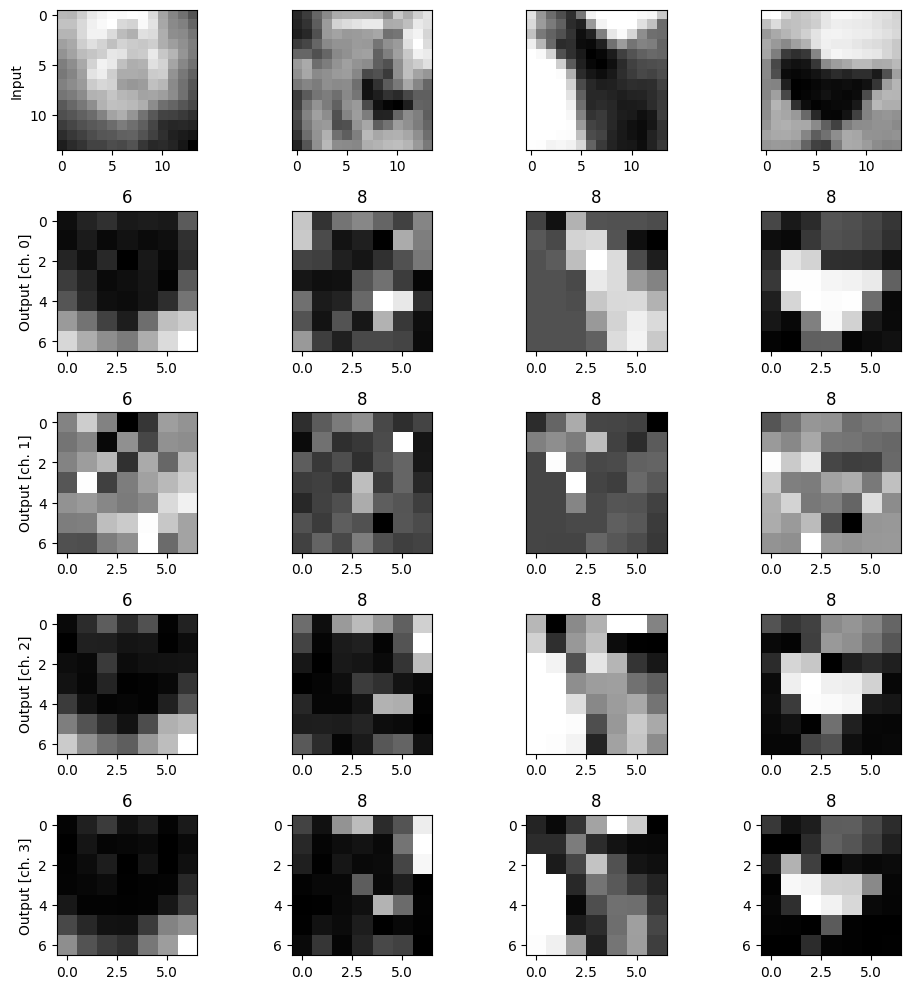

In [128]:
# Visualise the inputs/outputs from the quanv function
l_inputs = inputs.cpu()
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(l_inputs[k, 0, :, :], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].set_title(f"{labels[c+(k*n_samples)]}")
        axes[c + 1, k].imshow(outputs[k, c, :, :], cmap="gray")

plt.tight_layout()
plt.show()

### Create Data Loaders

Data loaders for both the training and test/validation datasets are created here. In both cases, a random selection of n_train and n_test objects are taken from the full MNIST dataset.

The indices of the selected objects are saved to a file ("dataset_indices.pt") so they can be reused at a later time if desired. The REGENERATE_INDICES_FILE should be set to *False* if a previously saved set of dataset indices is to be used and set to *True* if a new randomly selected set of indices should be used.

Note that on colab, any saved index files should be downloaded to your local computer since colab will delete such files when the session is disconnected.

In [ ]:

import os
from pathlib import Path
from torch.utils.data import Subset, DataLoader

os.chdir("Enter your current directory path here")

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

REGENERATE_INDICES_FILE = True

SUBSET_INDICES_FILE = Path("dataset_indices.pt")
# Randomly generate indexes for the training and test/validation
# images from the overall dataset. This only needs to be done
# once with subsequent runs reading the indices from the saved file.
#
if REGENERATE_INDICES_FILE is True:
    train_indices = torch.randint(0, len(train_data), (n_train,))
    test_indices = torch.randint(0, len(test_data), (n_test,))
    torch.save({"train_indices": train_indices, "test_indices": test_indices},
              SUBSET_INDICES_FILE)
subset_indices_dict = torch.load(SUBSET_INDICES_FILE)

train_subset = Subset(train_data, subset_indices_dict['train_indices'])
test_subset = Subset(test_data, subset_indices_dict['test_indices'])

train_loader = DataLoader(train_subset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(test_subset, shuffle=False, batch_size=batch_size)
print(f"{len(train_subset)=}")
print(f"{len(test_subset)=}")

len(train_subset)=1000
len(test_subset)=200


In [ ]:
class ImprovedUltraLightCNN(nn.Module):
    def __init__(self):
        super(ImprovedUltraLightCNN, self).__init__()
        
        # Single convolutional layer with exactly 4 trainable parameters
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=2,
            stride=1,
            padding=0,
            bias=False
        )
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(36, 50)
        self.fc2 = nn.Linear(50, 10)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='leaky_relu', a=0.1)
        
        nn.init.xavier_normal_(self.fc1.weight, gain=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fc2.weight, gain=0.1)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        if x.shape[1] == 3:
            x = torch.mean(x, dim=1, keepdim=True)
        
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        
        x = self.pool(x)
        
        x = torch.flatten(x, 1)
        
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_parameter_breakdown(self):
        breakdown = {
            'conv1.weight': self.conv1.weight.numel(),
            'fc1.weight': self.fc1.weight.numel(),
            'fc1.bias': self.fc1.bias.numel(),
            'fc2.weight': self.fc2.weight.numel(),
            'fc2.bias': self.fc2.bias.numel(),
        }
        breakdown['total'] = sum(breakdown.values())
        return breakdown

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=10, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
    
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

def get_improved_data_transforms():
    return {
        'train': transforms.Compose([
            transforms.Resize(16),  # Slight oversampling
            transforms.RandomCrop(14, padding=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])  # ImageNet grayscale stats
        ]),
        'val': transforms.Compose([
            transforms.Resize(14),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])
    }

def train_model_with_improvements(model, train_loader, val_loader, epochs=50, device='cuda'):
    model = model.to(device)
    
    criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)
    
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    max_grad_norm = 1.0
    
    best_acc = 0.0
    best_model_wts = None
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                
                optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        model.eval()
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(labels)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {epoch_loss:.4f} | '
              f'Train Acc: {epoch_acc:.4f} | '
              f'Val Acc: {val_acc:.4f} | '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
    
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    print(f'Best validation accuracy: {best_acc:.4f}')
    return model, best_acc

def calculate_model_parameters():
    model = ImprovedUltraLightCNN()
    total_params = model.count_parameters()
    breakdown = model.get_parameter_breakdown()
    
    print(f"Total trainable parameters: {total_params:,}")
    print("Parameter breakdown:")
    for layer, params in breakdown.items():
        if layer != 'total':
            print(f"  {layer}: {params:,} parameters")
    print(f"  Total: {breakdown['total']:,} parameters")
    print(f"Within 2000 parameter limit: {total_params <= 2000}")
    print(f"Convolutional kernel parameters: {model.conv1.weight.numel()} (target: 4)")
    print("=" * 40)

### Training Loop

In [ ]:
import datetime
from pathlib import Path
import time

dataset  = train_data

# Initialize your QCNN model
#cnn = QuantModel().to(device)
cnn = ImprovedUltraLightCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.SGD(cnn.parameters(), lr=initial_lr,
                      momentum=0.9)  # Stochastic Gradient Descent optimizer

# Create a learning rate scheduler
# Here, we use StepLR which reduces the learning rate by a factor every step_size epochs
#
# Setting step_size = 1.0 will effectively disable the scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0)

train_loader = DataLoader(train_subset, shuffle=False, batch_size=batch_size)

MODEL_NAME = "ImgClass-Quanvolv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

RESUME_TRAINING = False

if RESUME_TRAINING is True:
    print(f"Restore model state from {MODEL_SAVE_PATH}")
    model_dict = torch.load(MODEL_SAVE_PATH)
    initial_epoch = model_dict['epoch'] + 1
    cnn.load_state_dict(model_dict['model_state_dict'])
    optimizer.load_state_dict(model_dict['optimizer_state_dict'])
    loss_list = model_dict['loss'].copy()
else:
    initial_epoch = 0
    loss_list = []

for epoch in range(initial_epoch, num_epochs):
    cnn.train()
    ct = datetime.datetime.now()
    lr = scheduler.get_last_lr()
    print(f"{epoch=}, {lr=}, {ct}")
    running_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients to avoid accumulation
        outputs = cnn(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        running_loss.append(loss.item())
        optimizer.step()  # Update the model parameters
    loss_list.append(sum(running_loss)/len(running_loss))

    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / num_epochs, loss_list[-1]))
    torch.save({
        'epoch': epoch,
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_list,
    }, MODEL_SAVE_PATH)
    print(f"Saving model state to {MODEL_SAVE_PATH}")

    val_loader = DataLoader(test_subset, shuffle=False, batch_size=batch_size)
    correct = 0
    total = 0
    # Set the model to evaluation mode
    cnn.eval()
    with torch.inference_mode():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on the validation set: {100 * correct / total:.2f}%')

    # Decay Learning Rate
    scheduler.step()
print('Finished Training')

epoch=0, lr=[0.003], 2025-12-04 21:52:00.543320
Training [2%]	Loss: 2.3037
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 11.00%
epoch=1, lr=[0.003], 2025-12-04 21:52:03.121681
Training [5%]	Loss: 2.3029
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 11.00%
epoch=2, lr=[0.003], 2025-12-04 21:52:05.825285
Training [8%]	Loss: 2.3026
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 11.00%
epoch=3, lr=[0.003], 2025-12-04 21:52:08.780532
Training [10%]	Loss: 2.3024
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 11.00%
epoch=4, lr=[0.003], 2025-12-04 21:52:11.518934
Training [12%]	Loss: 2.3023
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 11.00%
epoch=5, lr=[0.003], 2025-12-04 21:52:14.259254
Training [15%]	Loss: 2.3022
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 11.00%
epoch=6

In [154]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ImprovedUltraLightCNN()
transforms = get_improved_data_transforms()
trained_model, best_acc = train_model_with_improvements(
    model, train_loader, val_loader, epochs=40, device=device
)

Epoch 1/50 | Train Loss: 2.3031 | Train Acc: 0.0960 | Val Acc: 0.1100 | LR: 0.000999
Epoch 2/50 | Train Loss: 2.3021 | Train Acc: 0.1050 | Val Acc: 0.1100 | LR: 0.000996
Epoch 3/50 | Train Loss: 2.3000 | Train Acc: 0.1140 | Val Acc: 0.1100 | LR: 0.000991
Epoch 4/50 | Train Loss: 2.2958 | Train Acc: 0.1160 | Val Acc: 0.1050 | LR: 0.000984
Epoch 5/50 | Train Loss: 2.2876 | Train Acc: 0.1390 | Val Acc: 0.1400 | LR: 0.000976
Epoch 6/50 | Train Loss: 2.2769 | Train Acc: 0.1590 | Val Acc: 0.1500 | LR: 0.000965
Epoch 7/50 | Train Loss: 2.2657 | Train Acc: 0.1550 | Val Acc: 0.1850 | LR: 0.000952
Epoch 8/50 | Train Loss: 2.2545 | Train Acc: 0.1730 | Val Acc: 0.1700 | LR: 0.000938
Epoch 9/50 | Train Loss: 2.2461 | Train Acc: 0.1690 | Val Acc: 0.1750 | LR: 0.000922
Epoch 10/50 | Train Loss: 2.2422 | Train Acc: 0.1720 | Val Acc: 0.1700 | LR: 0.000905
Epoch 11/50 | Train Loss: 2.2354 | Train Acc: 0.1770 | Val Acc: 0.1600 | LR: 0.000885
Epoch 12/50 | Train Loss: 2.2313 | Train Acc: 0.1760 | Val Acc:

### Model Inference

The problem with the 'IndexError' exception has now been fixed.

In [ ]:


#accuracy

# Use a small subset of the full validation dataset
from torch.utils.data import SubsetRandomSampler

K = n_test # enter your length here
subsample_train_indices = torch.randperm(len(val_set))[:K]
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, sampler=SubsetRandomSampler(subsample_train_indices))

correct = 0
total = 0
# Set the model to evaluation mode
cnn.eval()
with torch.inference_mode():
    for data in val_loader:
        images, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on the validation set: {100 * correct / total:.2f}%')

Accuracy on the validation set: 23.00%


In [ ]:
from torchsummary import summary
summary(model, (1, 14, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 13, 13]               4
         MaxPool2d-2              [-1, 1, 6, 6]               0
            Linear-3                   [-1, 50]           1,850
           Dropout-4                   [-1, 50]               0
            Linear-5                   [-1, 10]             510
Total params: 2,364
Trainable params: 2,364
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
